In [94]:
# =========================
# Section 1 — Setup and Environment
# =========================

# Core
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from lightgbm import LGBMClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    brier_score_loss,
    confusion_matrix
)

# Fairness
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate

# Explainability
import shap

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot defaults (paper-friendly)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 11
sns.set_style("whitegrid")

print("Environment ready.")


Environment ready.


In [99]:
# =========================
# Section 2 — Data Loading and Cleaning
# =========================

# Path to cleaned data
DATA_PATH = "sp500_clean.csv"

# Load data
df = pd.read_csv(DATA_PATH)

# Standardise column names
df.columns = df.columns.str.lower().str.strip()

# Parse date column
df["date"] = pd.to_datetime(df["date"])

# Sort by time to avoid leakage
df = df.sort_values("date").reset_index(drop=True)

# Basic inspection
print("Dataset shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

# Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Check duplicate dates
dup_dates = df["date"].duplicated().sum()
print("\nDuplicate dates:", dup_dates)

# Final confirmation
assert dup_dates == 0, "Duplicate dates detected"
assert df.isna().sum().sum() == 0, "Missing values detected"

print("\nData loaded, cleaned and validated.")


Dataset shape: (1258, 6)

Columns:
['date', 'close', 'high', 'low', 'open', 'volume']

Missing values per column:
date      0
close     0
high      0
low       0
open      0
volume    0
dtype: int64

Duplicate dates: 0

Data loaded, cleaned and validated.


In [100]:
# =========================
# Section 3 — Feature Engineering and Target Creation
# =========================

# Define feature columns (used for prediction)
FEATURES = ["open", "high", "low", "volume"]

# Confirm required columns exist
required_cols = FEATURES + ["close"]
missing_cols = [c for c in required_cols if c not in df.columns]
assert len(missing_cols) == 0, f"Missing columns: {missing_cols}"

# Create next-day close
df["close_next"] = df["close"].shift(-1)

# Binary target:
# 1 if next day's close is higher than today's close, else 0
df["next_day_up"] = (df["close_next"] > df["close"]).astype(int)

# Drop last row (no next-day value)
df = df.iloc[:-1].reset_index(drop=True)

# Inspect target distribution
target_counts = df["next_day_up"].value_counts(normalize=True).sort_index()

print("Features used:", FEATURES)
print("\nTarget distribution (next_day_up):")
print(target_counts)

# Clean up intermediate column
df.drop(columns=["close_next"], inplace=True)

print("\nFeature engineering and target creation complete.")


Features used: ['open', 'high', 'low', 'volume']

Target distribution (next_day_up):
next_day_up
0    0.463007
1    0.536993
Name: proportion, dtype: float64

Feature engineering and target creation complete.


In [101]:
# =========================
# Section 4 — Sensitive Group Construction (group_volatility)
# =========================

# Compute daily log returns
df["log_return"] = np.log(df["close"]).diff()

# Rolling volatility (20-day window, common in finance)
df["volatility"] = df["log_return"].rolling(window=20).std()

# Drop initial rows with insufficient window
df = df.dropna().reset_index(drop=True)

# Create volatility groups using quantiles
df["group_volatility"] = pd.qcut(
    df["volatility"],
    q=3,
    labels=["low", "med", "high"]
)

# Ensure clean categorical type and ordering
df["group_volatility"] = pd.Categorical(
    df["group_volatility"],
    categories=["low", "med", "high"],
    ordered=True
)

# Inspect group distribution
print("Volatility group distribution:")
print(df["group_volatility"].value_counts().sort_index())

# Sanity checks
assert df["group_volatility"].isna().sum() == 0, "Missing volatility group labels"

print("\nSensitive group (group_volatility) constructed successfully.")

# Clean up intermediate columns not used for modelling
df.drop(columns=["log_return"], inplace=True)


Volatility group distribution:
group_volatility
low     412
med     413
high    412
Name: count, dtype: int64

Sensitive group (group_volatility) constructed successfully.


In [102]:
# =========================
# Section 5 — Train–Test Split (Time Ordered)
# =========================

# Define split ratio
TRAIN_FRAC = 0.8

N = len(df)
split_idx = int(TRAIN_FRAC * N)

# Create indices
train_idx = np.arange(0, split_idx)
test_idx  = np.arange(split_idx, N)

# Split features and target
X = df[FEATURES].copy()
y = df["next_day_up"].astype(int).copy()

X_train = X.iloc[train_idx]
X_test  = X.iloc[test_idx]

y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

# Sensitive attribute aligned with split
sens_train = df.iloc[train_idx]["group_volatility"]
sens_test  = df.iloc[test_idx]["group_volatility"]

# Basic checks
print("Train size:", len(X_train), "| Test size:", len(X_test))

print("\nTrain date range:",
      df.iloc[train_idx]["date"].min().date(),
      "→",
      df.iloc[train_idx]["date"].max().date())

print("Test date range:",
      df.iloc[test_idx]["date"].min().date(),
      "→",
      df.iloc[test_idx]["date"].max().date())

print("\nIndex continuity check:")
print("Last train index:", train_idx.max(),
      "| First test index:", test_idx.min())

# Sanity checks
assert train_idx.max() + 1 == test_idx.min(), "Index continuity violated"
assert len(X_train) + len(X_test) == len(df), "Split size mismatch"

print("\nTrain–test split completed successfully.")


Train size: 989 | Test size: 248

Train date range: 2020-01-31 → 2024-01-04
Test date range: 2024-01-05 → 2024-12-30

Index continuity check:
Last train index: 988 | First test index: 989

Train–test split completed successfully.


In [ ]:
# =========================
# Section 6 — Baseline Model (LightGBM)
# =========================

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss
import numpy as np

RANDOM_STATE = 42

# Define baseline model
baseline_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE
)

# Train model
baseline_model.fit(X_train, y_train)

# Predict probabilities and labels
y_prob_base = baseline_model.predict_proba(X_test)[:, 1]
y_pred_base = (y_prob_base >= 0.5).astype(int)

# Evaluate baseline performance
baseline_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_base),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_base),
    "brier": brier_score_loss(y_test, y_prob_base)
}

baseline_metrics


[LightGBM] [Info] Number of positive: 522, number of negative: 467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 989, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527806 -> initscore=0.111338
[LightGBM] [Info] Start training from score 0.111338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

{'accuracy': 0.4879032258064516,
 'balanced_accuracy': 0.5085702896625033,
 'brier': 0.26992424828242023}

In [106]:
# =========================
# Section 7 — Fairness Mitigation (Demographic Parity)
# =========================

# Define fairness constraint
dp_constraint = DemographicParity()

# Initialise fairness mitigator (no random_state in ExponentiatedGradient)
fair_model = ExponentiatedGradient(
    estimator=baseline_model,       # Baseline model as estimator
    constraints=dp_constraint,      # Demographic Parity constraint
    eps=0.05                        # Balanced fairness–performance trade-off
)

# Train fairness-mitigated model
fair_model.fit(
    X_train,
    y_train,
    sensitive_features=sens_train  # Sensitive feature (group_volatility)
)

# Predict labels on test set
y_pred_fair = fair_model.predict(X_test).astype(int)

print("Fairness-mitigated model training complete.")
print("Unique predictions (fair model):", np.unique(y_pred_fair))


[LightGBM] [Info] Number of positive: 522, number of negative: 467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 989, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527806 -> initscore=0.111338
[LightGBM] [Info] Start training from score 0.111338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [107]:
# =========================
# Section 7A — Overall Performance Metrics
# =========================
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss

# Baseline metrics
baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_bal_acc = balanced_accuracy_score(y_test, y_pred)
baseline_brier = brier_score_loss(y_test, y_prob)

# Fairness-mitigated metrics (label-based only)
fair_accuracy = accuracy_score(y_test, y_pred_fair)
fair_bal_acc = balanced_accuracy_score(y_test, y_pred_fair)

# Assemble table
perf_7a = pd.DataFrame(
    {
        "accuracy": [baseline_accuracy, fair_accuracy],
        "balanced_accuracy": [baseline_bal_acc, fair_bal_acc],
        "brier": [baseline_brier, np.nan]  # Fair model has no probabilities
    },
    index=["Baseline", "Fairness-mitigated"]
)

print("=== Section 7A: Overall Model Performance ===")
display(perf_7a.round(3))


=== Section 7A: Overall Model Performance ===


,accuracy,balanced_accuracy,brier
Baseline,0.488,0.509,0.27
Fairness-mitigated,0.492,0.510,NaN


In [108]:
# =========================
# Section 7B — Group-level Fairness Metrics
# =========================
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

# Sensitive feature for test set
sens_test = df.iloc[test_idx]["group_volatility"].astype(str).reset_index(drop=True)

# Baseline group metrics
mf_baseline = MetricFrame(
    metrics={
        "selection_rate": selection_rate,
        "accuracy": accuracy_score
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sens_test
)

# Fairness-mitigated group metrics
mf_fair = MetricFrame(
    metrics={
        "selection_rate": selection_rate,
        "accuracy": accuracy_score
    },
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=sens_test
)

print("=== Section 7B: Baseline performance by volatility group ===")
display(mf_baseline.by_group.round(3))

print("\n=== Section 7B: Fairness-mitigated performance by volatility group ===")
display(mf_fair.by_group.round(3))


=== Section 7B: Baseline performance by volatility group ===


,selection_rate,accuracy
group_volatility,,
high,0.263,0.579
low,0.388,0.460
med,0.333,0.511



=== Section 7B: Fairness-mitigated performance by volatility group ===


,selection_rate,accuracy
group_volatility,,
high,0.474,0.684
low,0.396,0.468
med,0.333,0.489


In [109]:
# =========================
# Section 7C — Demographic Parity Gap
# =========================

# Extract selection rates by group
sr_baseline = mf_baseline.by_group["selection_rate"]
sr_fair = mf_fair.by_group["selection_rate"]

# Demographic Parity gap definition
dp_gap_baseline = (sr_baseline - sr_baseline.mean()).abs().max()
dp_gap_fair = (sr_fair - sr_fair.mean()).abs().max()

dp_summary = pd.DataFrame(
    {
        "DP_gap": [dp_gap_baseline, dp_gap_fair]
    },
    index=["Baseline", "Fairness-mitigated"]
)

print("=== Section 7C: Demographic Parity Gap ===")
display(dp_summary.round(4))


=== Section 7C: Demographic Parity Gap ===


,DP_gap
Baseline,0.0652
Fairness-mitigated,0.0728


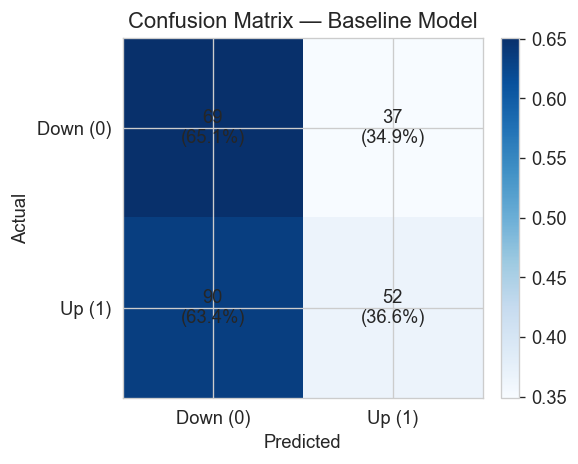

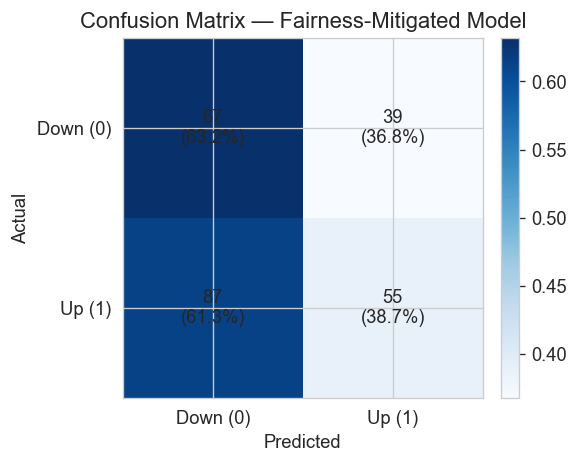

In [ ]:
# =========================
# Section 7D — Confusion Matrices
# =========================
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(5, 4))

    im = ax.imshow(cm_norm, cmap="Blues")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i,
                f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)",
                ha="center", va="center"
            )

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Down (0)", "Up (1)"])
    ax.set_yticklabels(["Down (0)", "Up (1)"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


# Baseline
plot_confusion_matrix(
    y_test,
    y_pred,
    "Confusion Matrix — Baseline Model"
)

# Fairness-mitigated
plot_confusion_matrix(
    y_test,
    y_pred_fair,
    "Confusion Matrix — Fairness-Mitigated Model"
)

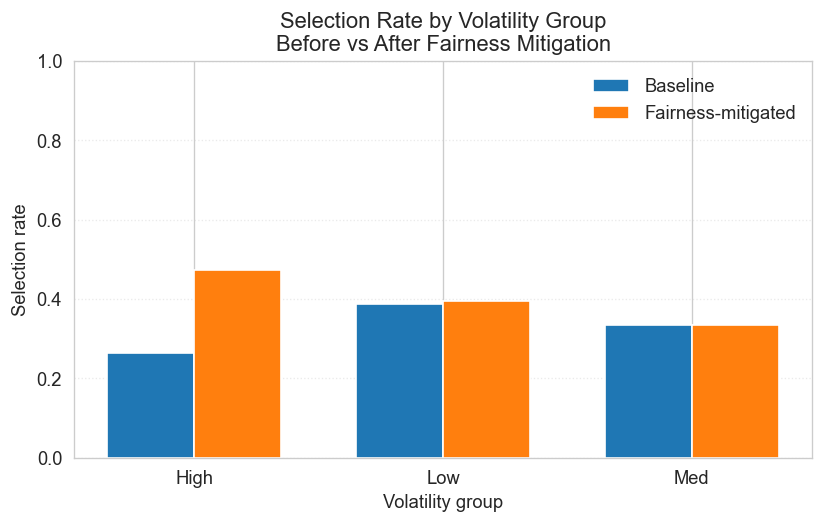

                  Baseline  Fairness-mitigated
group_volatility                              
high                 0.263               0.474
low                  0.388               0.396
med                  0.333               0.333


In [128]:
# =========================
# Section 7E — Selection Rate by Volatility Group
# =========================
import matplotlib.pyplot as plt
import numpy as np

# Extract selection rates
sr_base = mf_baseline.by_group["selection_rate"]
sr_fair = mf_fair.by_group["selection_rate"]

groups = sr_base.index.tolist()
x = np.arange(len(groups))
w = 0.35

fig, ax = plt.subplots(figsize=(7, 4.5))

ax.bar(x - w/2, sr_base.values, width=w, label="Baseline")
ax.bar(x + w/2, sr_fair.values, width=w, label="Fairness-mitigated")

ax.set_xticks(x)
ax.set_xticklabels([g.capitalize() for g in groups])
ax.set_ylabel("Selection rate")
ax.set_xlabel("Volatility group")
ax.set_title("Selection Rate by Volatility Group\nBefore vs After Fairness Mitigation")
ax.set_ylim(0, 1)

ax.legend(frameon=False)
ax.grid(axis="y", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()
# print ("=== Section 7E: Selection Rates by Volatility Group in a table ===")
selection_rates_df = pd.DataFrame({
    "Baseline": sr_base,
    "Fairness-mitigated": sr_fair
})
print(selection_rates_df.round(3))


In [110]:
# =========================
# Section 8A — SHAP (Baseline Model)
# =========================
import shap

# Use TreeExplainer for LightGBM
explainer_base = shap.TreeExplainer(baseline_model)

# Compute SHAP values on test set
shap_values_base = explainer_base.shap_values(X_test)

# Convert to DataFrame
shap_base_df = pd.DataFrame(
    np.abs(shap_values_base),
    columns=X_test.columns
)

# Global importance (mean |SHAP|)
shap_base_importance = shap_base_df.mean().sort_values(ascending=False)

print("=== Global mean |SHAP| — Baseline ===")
display(shap_base_importance.round(4))


=== Global mean |SHAP| — Baseline ===


high      0.5835
volume    0.2948
open      0.2304
low       0.0754
dtype: float64

In [112]:
# =========================
# Section 8B — SHAP (Fairness-Mitigated Model)
# =========================

# Identify dominant estimator in the fairness ensemble
dominant_idx = np.argmax(fair_model.weights_)
fair_estimator = fair_model.predictors_[dominant_idx]

print("Dominant fair estimator weight:", round(fair_model.weights_[dominant_idx], 4))

# SHAP explainer for dominant estimator
explainer_fair = shap.TreeExplainer(fair_estimator)

# SHAP values
shap_values_fair = explainer_fair.shap_values(X_test)

# Convert to DataFrame
shap_fair_df = pd.DataFrame(
    np.abs(shap_values_fair),
    columns=X_test.columns
)

# Global importance
shap_fair_importance = shap_fair_df.mean().sort_values(ascending=False)

print("=== Global mean |SHAP| — Fairness-Mitigated ===")
display(shap_fair_importance.round(4))


Dominant fair estimator weight: 0.9846
=== Global mean |SHAP| — Fairness-Mitigated ===


high      0.5718
open      0.3205
volume    0.3073
low       0.1630
dtype: float64

In [113]:
# =========================
# Section 8C — SHAP Comparison Table
# =========================

shap_compare = pd.concat(
    [
        shap_base_importance.rename("Baseline"),
        shap_fair_importance.rename("Fair")
    ],
    axis=1
)

print("=== Global mean |SHAP| comparison ===")
display(shap_compare.round(4))


=== Global mean |SHAP| comparison ===


,Baseline,Fair
high,0.5835,0.5718
volume,0.2948,0.3073
open,0.2304,0.3205
low,0.0754,0.1630


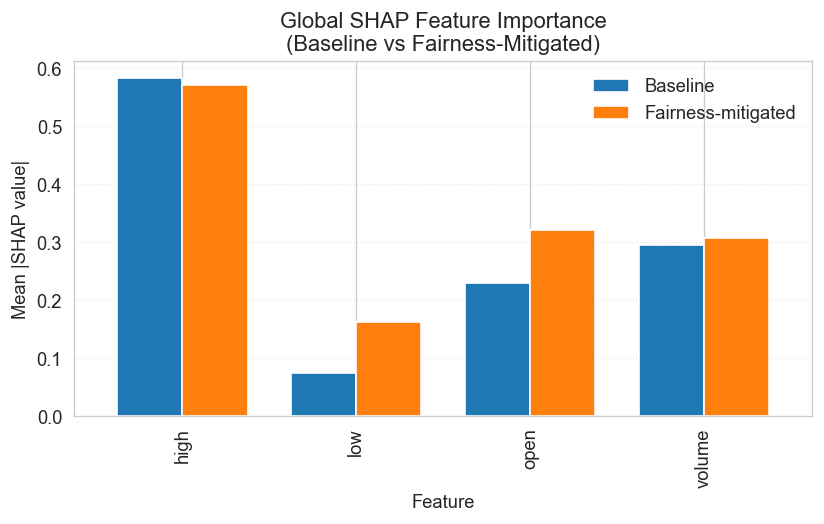

        Baseline  Fairness-mitigated
high       0.584               0.572
low        0.075               0.163
open       0.230               0.321
volume     0.295               0.307


In [154]:
# =========================
# Section 8D — SHAP Bar Plot (Figure 2)
# =========================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4.5))

shap_compare.plot(
    kind="bar",
    ax=ax,
    width=0.75
)

ax.set_title("Global SHAP Feature Importance\n(Baseline vs Fairness-Mitigated)")
ax.set_ylabel("Mean |SHAP value|")
ax.set_xlabel("Feature")
ax.legend(frameon=False)
ax.grid(axis="y", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()
# print ("=== Section 8D: SHAP Importance Comparison Table ===")
shap_compare = pd.DataFrame({
    "Baseline": shap_base_importance,
    "Fairness-mitigated": shap_fair_importance
})  
print(shap_compare.round(3))

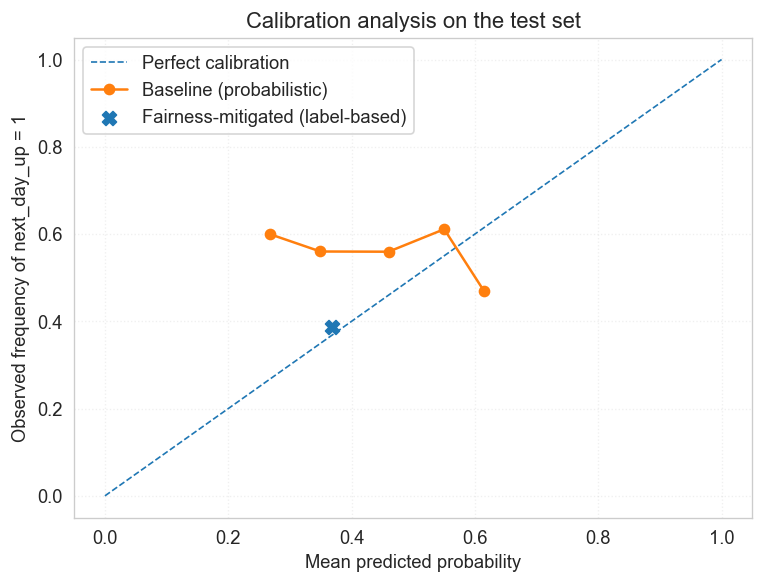

In [155]:
# =========================
# Figure 8 (From code) — Calibration curve (Baseline)
# =========================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix

# --- Baseline calibration ---
n_bins = 10
base_frac, base_mean = calibration_curve(
    y_test,
    y_prob_base,
    n_bins=n_bins,
    strategy="uniform"
)

# --- Fairness-mitigated reference point (label-based proxy) ---
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fair).ravel()
fair_fpr = fp / (fp + tn)
fair_tpr = tp / (tp + fn)

# --- Plot ---
fig, ax = plt.subplots(figsize=(6.5, 5))

# Perfect calibration
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Perfect calibration")

# Baseline curve
ax.plot(
    base_mean,
    base_frac,
    marker="o",
    label="Baseline (probabilistic)"
)

# Fairness reference point
ax.scatter(
    fair_fpr,
    fair_tpr,
    s=70,
    marker="X",
    label="Fairness-mitigated (label-based)"
)

ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed frequency of next_day_up = 1")
ax.set_title("Calibration analysis on the test set")
ax.grid(alpha=0.3, linestyle=":")
ax.legend()

plt.tight_layout()
plt.show()

# Optional save
# fig.savefig("figure8_calibration.png", dpi=300, bbox_inches="tight")


In [115]:
# =========================
# Section 9A — Calibration Metrics
# =========================
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Brier score (already computed earlier, recomputed here for clarity)
brier_baseline = brier_score_loss(y_test, y_prob)

# Expected Calibration Error (ECE)
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = bin_ids == i
        if np.any(mask):
            bin_acc = y_true[mask].mean()
            bin_conf = y_prob[mask].mean()
            ece += np.abs(bin_acc - bin_conf) * mask.mean()
    return ece

ece_baseline = expected_calibration_error(y_test.values, y_prob)

print("=== Calibration summary ===")
print(f"Baseline:  ECE={ece_baseline:.3f} | Brier={brier_baseline:.3f}")


=== Calibration summary ===
Baseline:  ECE=0.137 | Brier=0.270


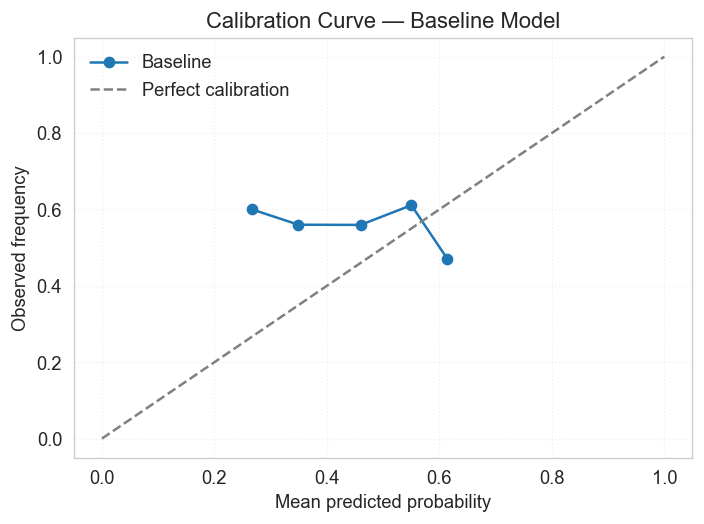

In [116]:
# =========================
# Section 9B — Calibration Curve (Figure 3)
# =========================
import matplotlib.pyplot as plt

# Calibration curve
frac_pos, mean_pred = calibration_curve(
    y_test, y_prob, n_bins=10, strategy="uniform"
)

fig, ax = plt.subplots(figsize=(6, 4.5))

ax.plot(mean_pred, frac_pos, marker="o", label="Baseline")
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")

ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed frequency")
ax.set_title("Calibration Curve — Baseline Model")
ax.legend(frameon=False)
ax.grid(alpha=0.3, linestyle=":")

plt.tight_layout()
plt.show()


In [119]:
# =========================
# Section 10A — Trading Signal Preparation
# =========================

# Daily log returns
df_test = df.iloc[test_idx].copy()
df_test["log_return"] = np.log(df_test["close"]).diff()

# Align predictions
df_test["signal_baseline"] = y_pred
df_test["signal_fair"] = y_pred_fair

# Drop first row due to diff
df_test = df_test.iloc[1:].reset_index(drop=True)

# =========================
# Section 10B — Strategy Returns
# =========================

df_test["ret_baseline"] = df_test["signal_baseline"] * df_test["log_return"]
df_test["ret_fair"] = df_test["signal_fair"] * df_test["log_return"]

# Cumulative growth
df_test["cum_baseline"] = np.exp(df_test["ret_baseline"].cumsum())
df_test["cum_fair"] = np.exp(df_test["ret_fair"].cumsum())

# =========================
# Section 10C — Trading Performance Summary
# =========================

summary_10 = pd.DataFrame({
    "Final growth (×)": [
        df_test["cum_baseline"].iloc[-1],
        df_test["cum_fair"].iloc[-1]
    ],
    "Total return (%)": [
        (df_test["cum_baseline"].iloc[-1] - 1) * 100,
        (df_test["cum_fair"].iloc[-1] - 1) * 100
    ],
    "Days invested (%)": [
        df_test["signal_baseline"].mean() * 100,
        df_test["signal_fair"].mean() * 100
    ],
    "Signal switches": [
        (df_test["signal_baseline"].diff() != 0).sum(),
        (df_test["signal_fair"].diff() != 0).sum()
    ]
}, index=["Baseline", "Fairness-mitigated"])

print("=== Trading Performance Summary (Test Period) ===")
display(summary_10.round(3))


=== Trading Performance Summary (Test Period) ===


,Final growth (×),Total return (%),Days invested (%),Signal switches
Baseline,1.152,15.211,36.032,93
Fairness-mitigated,1.146,14.646,38.057,102


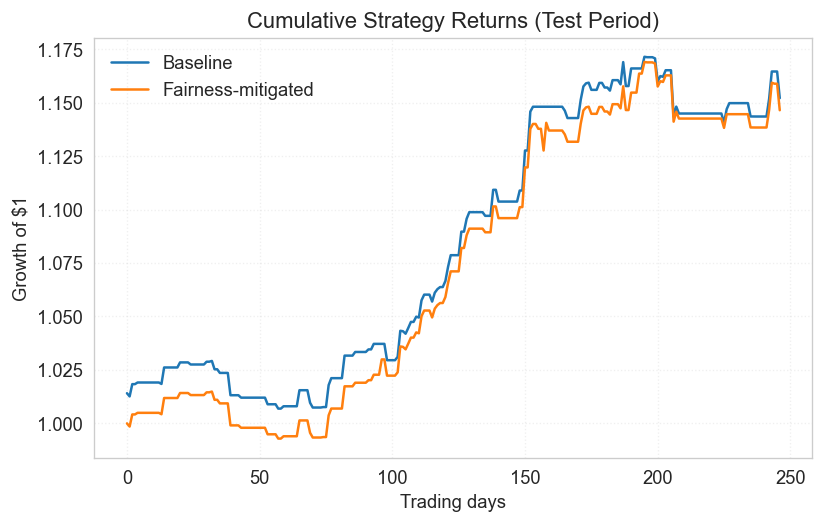

In [120]:
# =========================
# Section 10D — Cumulative Return Plot (Figure 6)
# =========================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4.5))

ax.plot(df_test["cum_baseline"], label="Baseline")
ax.plot(df_test["cum_fair"], label="Fairness-mitigated")

ax.set_title("Cumulative Strategy Returns (Test Period)")
ax.set_ylabel("Growth of $1")
ax.set_xlabel("Trading days")
ax.legend(frameon=False)
ax.grid(alpha=0.3, linestyle=":")

plt.tight_layout()
plt.show()


In [121]:
# =========================
# Section 11A — MLflow Setup
# =========================
import mlflow
import os

mlflow.set_experiment("Fairness-Aware Algorithmic Trading")


2025/12/15 18:23:45 INFO mlflow.tracking.fluent: Experiment with name 'Fairness-Aware Algorithmic Trading' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/DELL/Documents/GitHub/XAI%20Project/mlruns/590083108120657289', creation_time=1765819425307, experiment_id='590083108120657289', last_update_time=1765819425307, lifecycle_stage='active', name='Fairness-Aware Algorithmic Trading', tags={}>

In [122]:
# =========================
# Section 11B — Log Parameters and Metrics
# =========================
with mlflow.start_run(run_name="baseline_vs_fairness"):

    # ---- Parameters ----
    mlflow.log_param("model", "LightGBM")
    mlflow.log_param("fairness_constraint", "Demographic Parity")
    mlflow.log_param("sensitive_group", "group_volatility")
    mlflow.log_param("train_test_split", "time-ordered 80/20")

    # ---- Performance metrics (Section 7A) ----
    mlflow.log_metric("accuracy_baseline", baseline_accuracy)
    mlflow.log_metric("accuracy_fair", fair_accuracy)
    mlflow.log_metric("balanced_accuracy_baseline", baseline_bal_acc)
    mlflow.log_metric("balanced_accuracy_fair", fair_bal_acc)
    mlflow.log_metric("brier_baseline", baseline_brier)

    # ---- Fairness metrics (Section 7C) ----
    mlflow.log_metric("dp_gap_baseline", dp_gap_baseline)
    mlflow.log_metric("dp_gap_fair", dp_gap_fair)

    # ---- Calibration (Section 9) ----
    mlflow.log_metric("ece_baseline", ece_baseline)

    # ---- Trading performance (Section 10) ----
    mlflow.log_metric("final_growth_baseline", summary_10.loc["Baseline", "Final growth (×)"])
    mlflow.log_metric("final_growth_fair", summary_10.loc["Fairness-mitigated", "Final growth (×)"])

    print("MLflow logging complete.")


MLflow logging complete.


In [123]:
# =========================
# Section 11C — Log Figures
# =========================

for fig_name in [
    "figure2_shap_importance.png",
    "figure3_calibration.png",
    "figure6_cumulative_returns.png"
]:
    if os.path.exists(fig_name):
        mlflow.log_artifact(fig_name)


In [134]:
# =========================
# Section 3.3 — Target construction: next_day_up
# =========================

import pandas as pd

# Ensure data are sorted chronologically
df = df.sort_values("date").reset_index(drop=True)

# Create next-day closing price
df["close_next"] = df["close"].shift(-1)

# Construct binary target
df["next_day_up"] = (df["close_next"] > df["close"]).astype(int)

# Drop final row (no next-day close available)
df = df.dropna(subset=["close_next"]).reset_index(drop=True)

# Sanity check
print(df[["date", "close", "close_next", "next_day_up"]].head())
print("\nTarget distribution:")
print(df["next_day_up"].value_counts(normalize=True).round(3))


        date        close   close_next  next_day_up
0 2020-01-31  3225.520020  3248.919922            1
1 2020-02-03  3248.919922  3297.590088            1
2 2020-02-04  3297.590088  3334.689941            1
3 2020-02-05  3334.689941  3345.780029            1
4 2020-02-06  3345.780029  3327.709961            0

Target distribution:
next_day_up
1    0.538
0    0.462
Name: proportion, dtype: float64


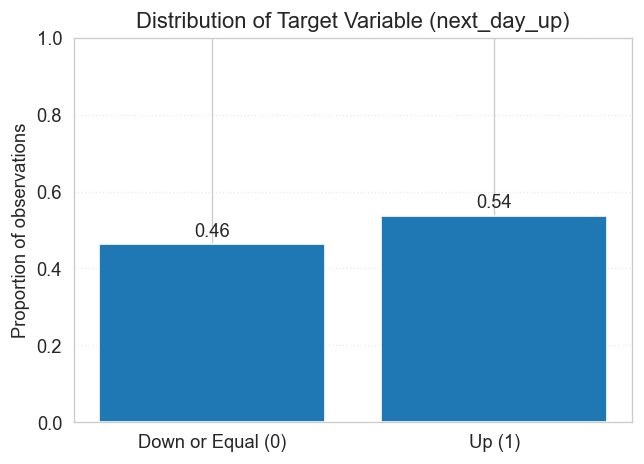

In [130]:
# =========================
# Target Distribution Plot — next_day_up
# =========================
import matplotlib.pyplot as plt

# Compute distribution
target_counts = df["next_day_up"].value_counts().sort_index()
target_props = df["next_day_up"].value_counts(normalize=True).sort_index()

# Plot
fig, ax = plt.subplots(figsize=(5.5, 4))

bars = ax.bar(
    ["Down or Equal (0)", "Up (1)"],
    target_props.values
)

# Annotate bars
for bar, pct in zip(bars, target_props.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{pct:.2f}",
        ha="center",
        va="bottom"
    )

ax.set_ylabel("Proportion of observations")
ax.set_title("Distribution of Target Variable (next_day_up)")
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()


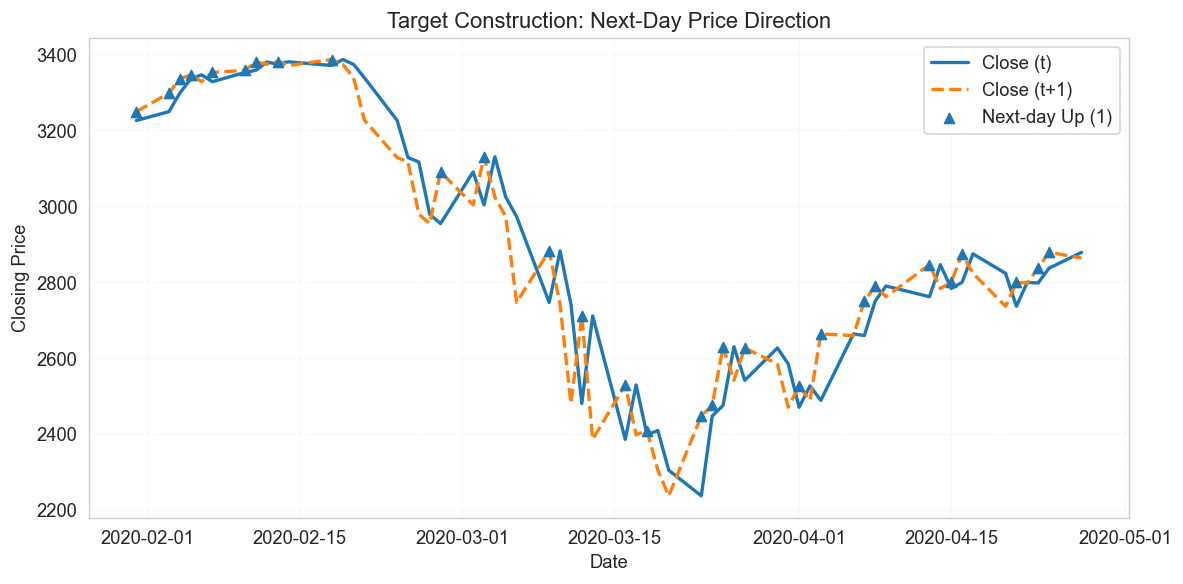

In [135]:
# =========================
# Figure X — Target Construction (next_day_up)
# =========================

import matplotlib.pyplot as plt

# Select a short window for visual clarity
plot_df = df[["date", "close", "close_next", "next_day_up"]].iloc[:60]

plt.figure(figsize=(10, 5))

# Plot current and next-day close
plt.plot(plot_df["date"], plot_df["close"],
         label="Close (t)", linewidth=2)

plt.plot(plot_df["date"], plot_df["close_next"],
         label="Close (t+1)", linestyle="--", linewidth=2)

# Highlight upward movements
up_days = plot_df["next_day_up"] == 1
plt.scatter(
    plot_df.loc[up_days, "date"],
    plot_df.loc[up_days, "close_next"],
    marker="^",
    label="Next-day Up (1)",
    zorder=3
)

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Target Construction: Next-Day Price Direction")
plt.legend()
plt.grid(alpha=0.3, linestyle=":")

plt.tight_layout()
plt.show()


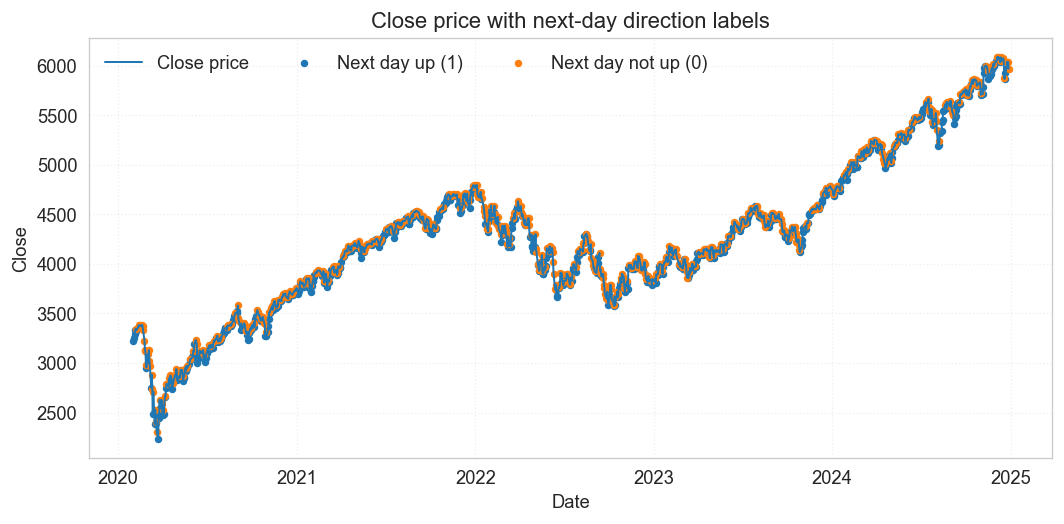

In [131]:
# =========================
# Optional Figure — Price path with next_day_up markers
# =========================
import matplotlib.pyplot as plt

# assumes df has: date, close, next_day_up (already created)
tmp = df[["date", "close", "next_day_up"]].copy()
tmp["date"] = pd.to_datetime(tmp["date"])

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(tmp["date"], tmp["close"], linewidth=1.2, label="Close price")

# markers for direction
up = tmp[tmp["next_day_up"] == 1]
dn = tmp[tmp["next_day_up"] == 0]

ax.scatter(up["date"], up["close"], s=12, label="Next day up (1)")
ax.scatter(dn["date"], dn["close"], s=12, label="Next day not up (0)")

ax.set_title("Close price with next-day direction labels")
ax.set_xlabel("Date")
ax.set_ylabel("Close")
ax.grid(alpha=0.3, linestyle=":")
ax.legend(frameon=False, ncol=3, loc="upper left")
plt.tight_layout()
plt.show()


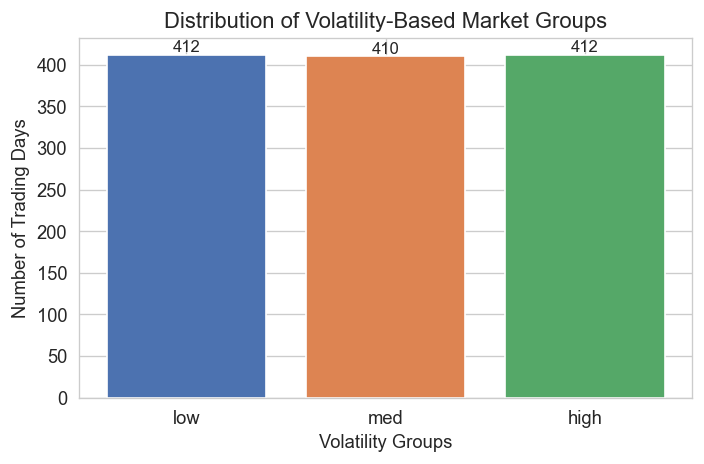

In [138]:
# =========================
# Figure X — Distribution of Volatility-Based Market Groups
# =========================

import matplotlib.pyplot as plt

# Count observations per volatility group
vol_counts = df["group_volatility"].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(
    vol_counts.index,
    vol_counts.values,
    color=["#4C72B0", "#DD8452", "#55A868"]
)

# Labels
plt.xlabel("Volatility Groups")
plt.ylabel("Number of Trading Days")
plt.title("Distribution of Volatility-Based Market Groups")

# Annotate bar values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


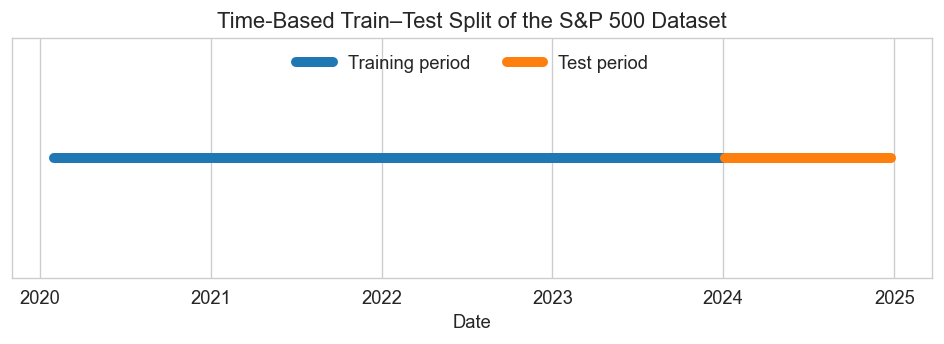

In [140]:
# =========================
# Figure X — Time-Based Train–Test Split
# =========================

import matplotlib.pyplot as plt

# Identify split date directly
split_date = df.loc[train_idx[-1], "date"]

# Separate train and test by date
train_dates = df[df["date"] <= split_date]["date"]
test_dates  = df[df["date"] > split_date]["date"]

# Plot timeline
plt.figure(figsize=(8, 3))

plt.plot(
    train_dates,
    [1] * len(train_dates),
    linewidth=6,
    label="Training period"
)

plt.plot(
    test_dates,
    [1] * len(test_dates),
    linewidth=6,
    label="Test period"
)

plt.yticks([])
plt.xlabel("Date")
plt.title("Time-Based Train–Test Split of the S&P 500 Dataset")
plt.legend(loc="upper center", ncol=2, frameon=False)

plt.tight_layout()
plt.show()


In [143]:
# =========================
# Table 1 — Baseline Predictive Performance
# =========================

import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss

# Compute metrics
baseline_results = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y_test, y_pred_base)],
        "Balanced Accuracy": [balanced_accuracy_score(y_test, y_pred_base)],
        "Brier Score": [brier_score_loss(y_test, y_prob_base)]
    },
    index=["Baseline"]
)

baseline_results


,Accuracy,Balanced Accuracy,Brier Score
Baseline,0.487903,0.50857,0.269924


In [144]:
# =========================
# Table 2 — Fairness-Mitigated Model Performance
# =========================

import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score

fair_results = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y_test, y_pred_fair)],
        "Balanced Accuracy": [balanced_accuracy_score(y_test, y_pred_fair)]
    },
    index=["Fairness-mitigated"]
)

fair_results


,Accuracy,Balanced Accuracy
Fairness-mitigated,0.491935,0.5097


In [147]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score
import pandas as pd

mf_baseline = MetricFrame(
    metrics={
        "Selection rate": selection_rate,
        "Accuracy": accuracy_score
    },
    y_true=y_test,
    y_pred=y_pred_base,
    sensitive_features=sens_test
)

mf_fair = MetricFrame(
    metrics={
        "Selection rate": selection_rate,
        "Accuracy": accuracy_score
    },
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=sens_test
)

group_fairness_table = pd.concat(
    {
        "Baseline": mf_baseline.by_group,
        "Fairness-mitigated": mf_fair.by_group
    },
    axis=1
)

group_fairness_table


Baseline           Fairness-mitigated          
                 Selection rate  Accuracy     Selection rate  Accuracy
group_volatility                                                      
high                   0.263158  0.578947           0.473684  0.684211
low                    0.388489  0.460432           0.395683  0.467626
med                    0.333333  0.511111           0.333333  0.488889